# ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **CHAPTER 8 - DIMENSIONALITY REDUCTION**

---

## **SETUP:**

In [2]:
# %load ../initial_settings.py
"""
Initial settings for data analysis and machine learning.
Use this with: %load ../initial_settings.py
"""

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import sklearn
from packaging import version

import matplotlib as mpl
import matplotlib.pyplot as plt

# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Graphviz source.
os.environ["PATH"] += os.pathsep + "C:/Programy/Graphviz/bin/"

# Default settings for matplotlib.
DARK_BLUE = "#03002e"
LIGHT_GRAY = "#8f8f99"

plt.rc("font", size=14)
plt.rc("legend", fontsize=14)
plt.rc("text", color=DARK_BLUE)

plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelpad=10)
plt.rc("axes", labelcolor=DARK_BLUE)
plt.rc("axes", grid=True)

plt.rc("xtick", labelsize=12, color=DARK_BLUE)
plt.rc("ytick", labelsize=12, color=DARK_BLUE)
plt.rc("xtick.major", pad=10)
plt.rc("ytick.major", pad=10)

plt.rc("grid", color=LIGHT_GRAY)
plt.rc("grid", linestyle="dashed")
plt.rc("grid", linewidth=0.5)
plt.rc("grid", alpha=0.5)

# Create a directory for matplotlib images.
IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)


---

## **PCA VISUALIZATIONS:**

Let's generate a small 3D dataset. It's an oval shape, rotated in 3D space, with points distributed unevenly, and with quite a lot of noise:

In [7]:
from scipy.spatial.transform import Rotation

np.random.seed(42)

m = 60
X = np.zeros((m, 3))
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles)  # Oval.
X += 0.28 * np.random.randn(m, 3)  # More noise.
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi /4]).apply(X)
X += [0.2, 0, 0.2]  # Shift a bit.

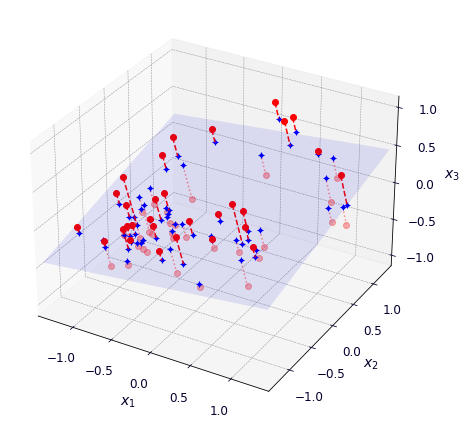

In [87]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # Dataset reduced to 2D.
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples.
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # Projection plane coefs.
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # Plane.
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # Samples above plane.
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # Samples below plane.

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection="3d")

# Samples and projection lines below plane.
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # Projection plane.
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # Projected samples.
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# Samples and projection lines above plane.
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=14, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=14, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=14, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("dataset_3d_plot")
plt.show()

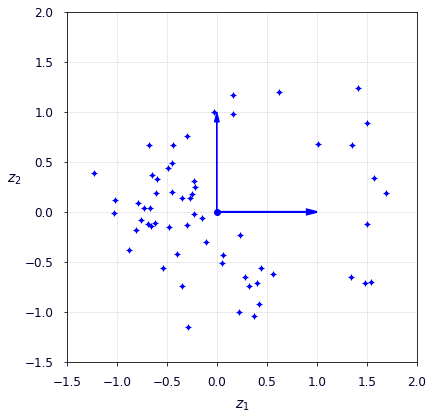

In [57]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc="b", ec="b", linewidth=2)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc="b", ec="b", linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0)
ax.set_xlim(-1.5, 2.0)
ax.set_ylim(-1.5, 2.0)
ax.set_axisbelow(True)
save_fig("dataset_2d")
plt.show()

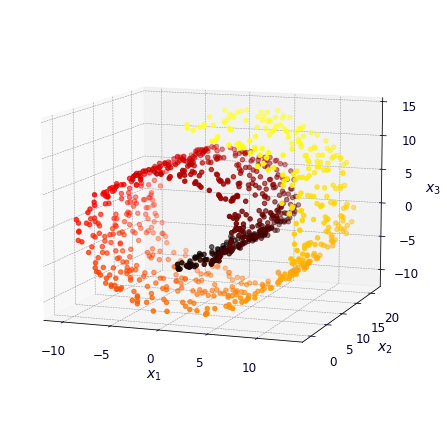

In [88]:
from sklearn.datasets import make_swiss_roll
from matplotlib.colors import ListedColormap

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))  # type: ignore
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection="3d")

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)  # type: ignore
set_xyz_axes(ax, axes)

save_fig("swiss_roll")
plt.show()

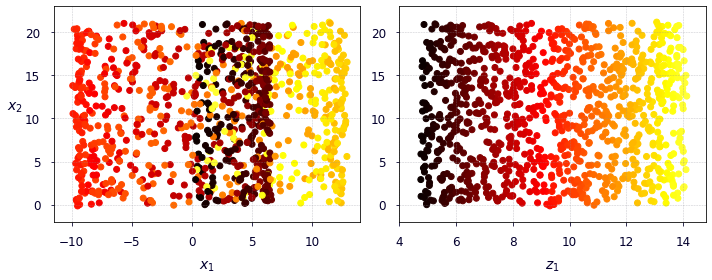

In [110]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)

plt.subplot(1, 2, 2)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")

save_fig("squished_swiss_roll")
plt.show()

In [96]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

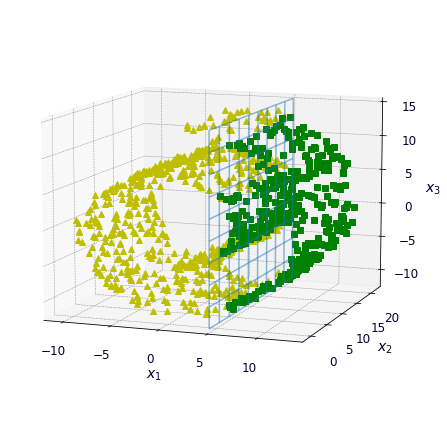

In [100]:
positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)  # type: ignore
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)  # type: ignore
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
save_fig("manifold_decision_boundary_plot1")
plt.show()

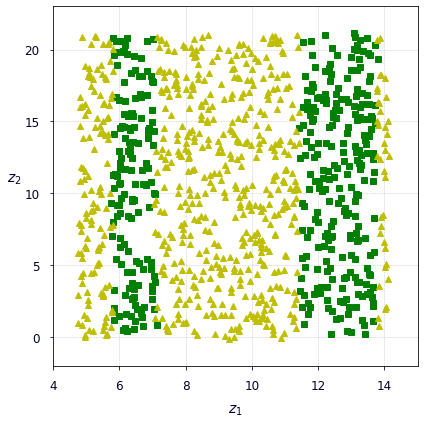

In [102]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0)
save_fig("manifold_decision_boundary_plot2")
plt.show()

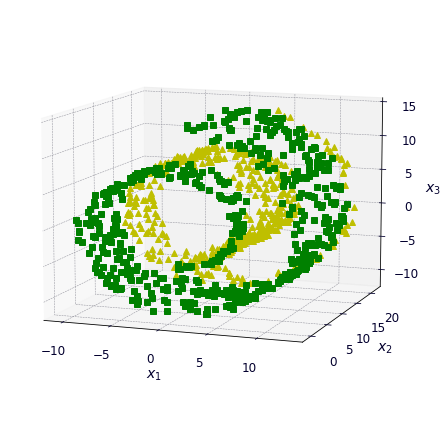

In [104]:
positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1, projection="3d")
ax.view_init(10, -70)  # type: ignore
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
save_fig("manifold_decision_boundary_plot3")
plt.show()

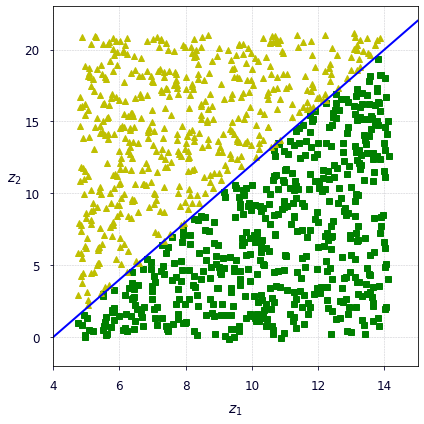

In [105]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0)
save_fig("manifold_decision_boundary_plot4")
plt.show()

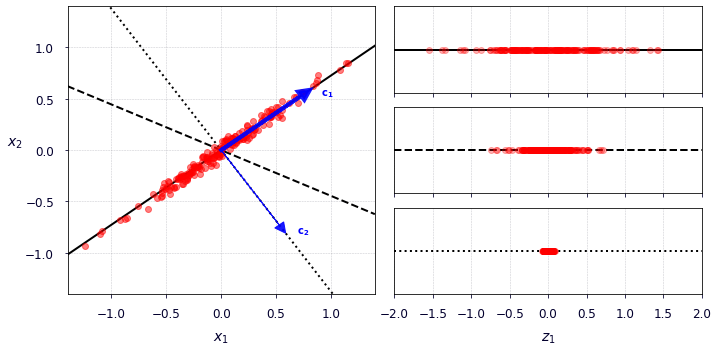

In [119]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(10, 5))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")

save_fig("pca_best_projection")
plt.show()

---

## **PRINCIPAL COMPONENTS:**

### **1. CALCULATE PRINCIPAL COMPONENTS:**

In [122]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [129]:
Vt

array([[ 0.67291313,  0.70597236,  0.22088672],
       [-0.73251346,  0.67753858,  0.06607197],
       [-0.10301429, -0.20626319,  0.97305886]])

Note: in principle, the SVD factorization algorithm returns three matrices, **U**, **Σ** and **V**, such that **X** = **UΣV**<sup>⊺</sup>, where **U** is an _m_ × _m_ matrix, **Σ** is an _m_ × _n_ matrix, and **V** is an _n_ × _n_ matrix. But the `svd()` function returns **U**, **s** and **V**<sup>⊺</sup> instead. **s** is the vector containing all the values on the main diagonal of the top _n_ rows of **Σ**. Since **Σ** is full of zeros elsewhere, your can easily reconstruct it from **s**, like this:

In [123]:
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

### **2. PROJECTING DOWN TO D DIMENSIONS:**

In [126]:
W2 = Vt[:2].T
X2D = X_centered @ W2

### **3. PCA WITH SCIKIT-LEARN:**

In [131]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [132]:
pca.components_

array([[ 0.67291313,  0.70597236,  0.22088672],
       [-0.73251346,  0.67753858,  0.06607197]])

In [133]:
pca.explained_variance_ratio_

array([0.58776194, 0.34244861])

The first dimension explains about 59% of the variance, while the second explains about 34%.

By projecting down to 2D, we lost about 7% of the variance:

In [134]:
1 - pca.explained_variance_ratio_.sum()

0.06978945136234183

### **4. CHOOSING THE RIGHT NUMBER OF DIMENSIONS:**

In [135]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [136]:
pca = PCA(n_components=0.95)  # Provide 95% of variance.
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [137]:
pca.explained_variance_ratio_.sum()

0.9501960192613031

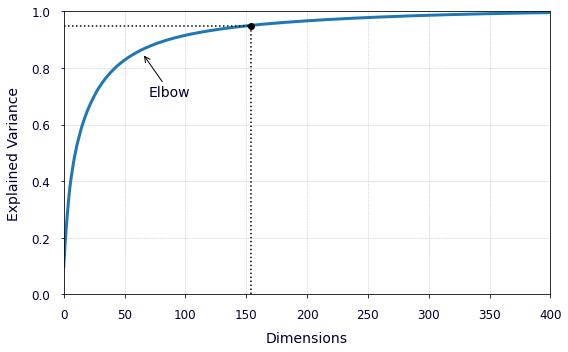

In [144]:
plt.figure(figsize=(8, 5))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=14)

save_fig("explained_variance")
plt.show()

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [146]:
rnd_search.best_params_

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}

In [147]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {
    "pca__n_components": np.arange(10, 80),
}

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [148]:
grid_search.best_params_

{'pca__n_components': 67}

### **5. PCA FOR COMPRESSION:**

In [163]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

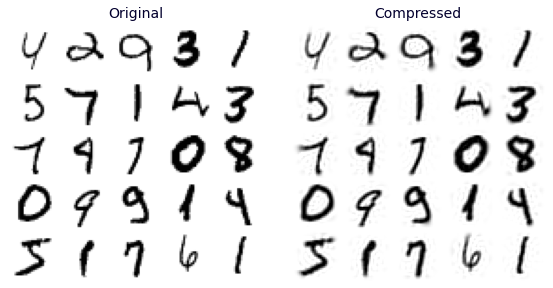

In [164]:
plt.figure(figsize=(8, 4))

for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")
            
save_fig("mnist_compression")
plt.show()

### **6. RANDOMIZED PCA:**

In [165]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### **7. INCREMENTAL PCA:**

In [166]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

**Using NumPy's `memmap` class – a memory-map to an array stored in a binary file on disk.**

Let's create the `memmap` instance, copy the MNIST training set into it, and call `flush()` which ensures that any data still in cache is saved to disk. This would typically be done by a first program:

In [167]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype="float32", mode="write", shape=X_train.shape)
X_mmap[:] = X_train  # Could be a loop instead, saving the data chunk by chunk.
X_mmap.flush()

Next, another program would load the data and use it for training:

In [168]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

---

## **KERNEL PCA:**

In [185]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

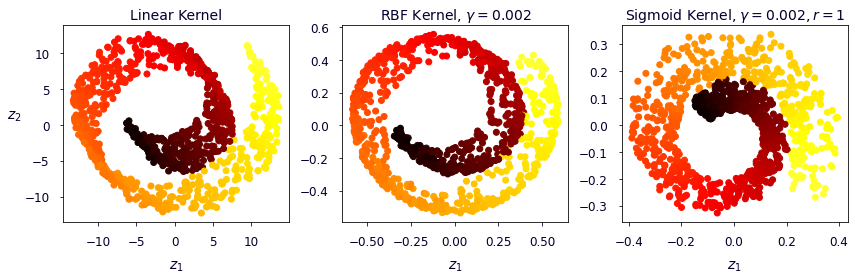

In [186]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = ((lin_pca, "Linear Kernel"),
               (rbf_pca, rf"RBF Kernel, $\gamma={rbf_pca.gamma}$"),
               (sig_pca, rf"Sigmoid Kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"))

plt.figure(figsize=(12, 4))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

save_fig("kernel_pca")
plt.show()

---

## **RANDOM PROJECTION:**

In [169]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, eps = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=eps)
d

7300

In [170]:
d = int(4 * np.log(m) / (eps ** 2 / 2 - eps ** 3 / 3))
d

7300

In [171]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # std dev = square root of variance

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T

In [173]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=eps, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # same result as above

In [174]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [175]:
from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
3.64 s ± 54.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
2.53 s ± 65.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
9.3 s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
4.45 s ± 89.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

## **LOCALLY LINEAR EMBEDDING:**

In [176]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

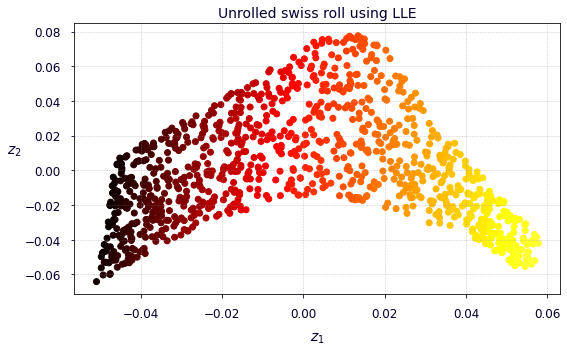

In [177]:
plt.figure(figsize=(8, 5))
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.title("Unrolled swiss roll using LLE")
save_fig("lle_unrolling")
plt.show()

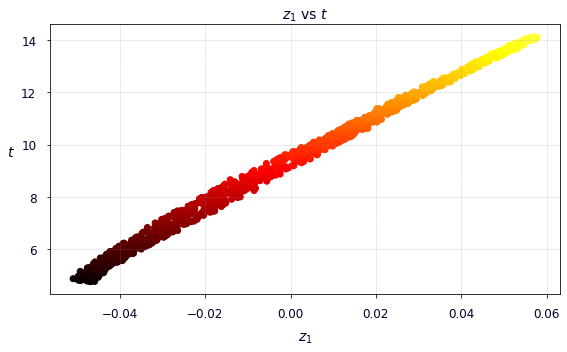

In [179]:
plt.figure(figsize=(8, 5))
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.title("$z_1$ vs $t$")
save_fig("lle_unrolling_z1_vs_t")
plt.show()

In [180]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [181]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

In [182]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

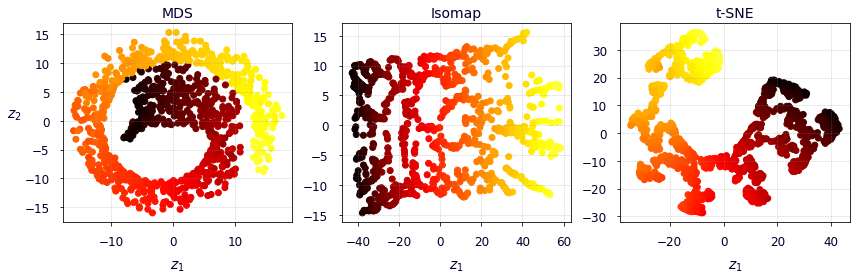

In [184]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(12, 4))

for subplot, title, X_reduced in zip((131, 132, 133), ("MDS", "Isomap", "t-SNE"),
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
        
save_fig("other_dim_reductions")
plt.show()